from torch.onnx._internal.fx._pass import Analysis
# 10. StaVia TI for Spatio-temporal Analysis of single cell data
This tutorial focuses on how to use StaVia on single cell atlases that have spatial and temporal data. We use a Stereo-seq Zebrafish gastrulation dataset ZESTA (C. Liu et al. 2022) from 5hpf to 24hpf of 150,000 spots approaching single cell size. The preprocessed anndata object with all slices and time points merged on shared genes is available [here](https://drive.google.com/drive/folders/1xAxCnRfblwWqAujJSs_sqNhTx40GqN6Y?usp=sharing).

We show how to incorporate both spatial coordinates of cells on different tissue slices as well as temporal labels from known experimental/developmental time points

In [1]:
import scanpy as sc, numpy as np, pandas as pd, pyVIA.core as via

# download and read the data. 
foldername = '/home/user/Spatial/datasets/Zesta/'
fname_outer = 'Data/steroseq_alltimes_outerjoin_26628genes.h5ad'  # outer join of genes from each time point
fname = 'Data/stavia_spatialPCA100_spatialk15_weightp3.h5ad' #contains the PCs on the spatially smoothed genes. adata.X is the original non-smoothed gene expression, but the PCA is based on the spatially-smoothed gene matrix (which we dont save as its a big dense matrix)
print('fname:', fname)
adata = sc.read(foldername + fname)
#ad_outer = sc.read(foldername + fname_outer)
print(adata)

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-pac

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/phate/__init__.py
fname: Data/stavia_spatialPCA100_spatialk15_weightp3.h5ad
AnnData object with n_obs × n_vars = 152977 × 13615
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'spatial_x', 'spatial_y', 'slice', 'time_point', 'bin_annotation', 'colors', 'layer_annotation', 'layer_colors', 'time_str', 'time_num', 'coarse_celltype', 'fine_celltype', 'coarse_fine_celltype', 'via_clusters', 'coarse_celltype_stavia', 'fine_celltype_stavia', 'coarse_fine_celltype_stavia'
    uns: 'pca'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_adjusted', 'spatial_pca'
    varm: 'PCs'
    layers: 'counts'


/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
true_labels_coarse = [i for i in adata.obs['coarse_celltype_stavia']]
true_labels_fine = [ i for i in adata.obs['fine_celltype_stavia']]
true_labels_hybrid = [i for i in adata.obs['coarse_fine_celltype_stavia']]

#### Plot the data
Let's have a quick look at the data. We plot the cells/spots based on their tissue coordinates and color them by time point.

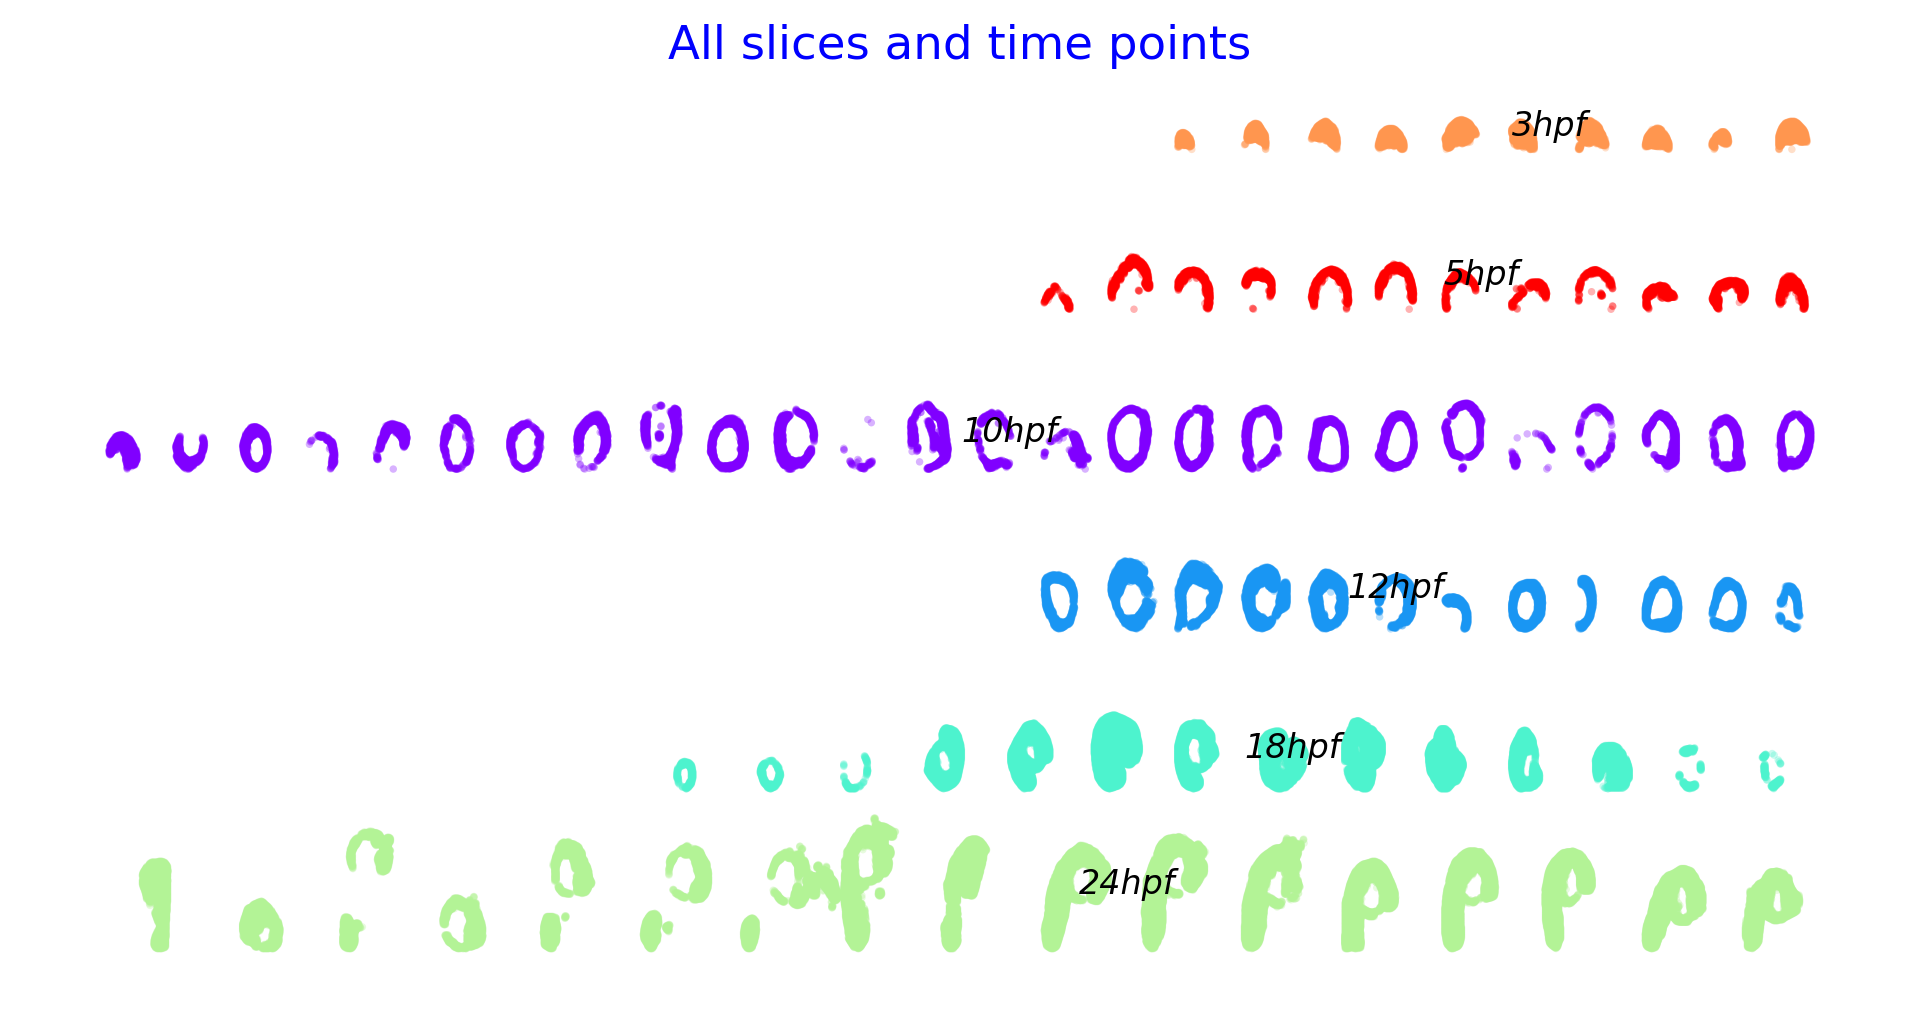

In [4]:
f,ax = via.plot_scatter(embedding=adata.obsm['X_spatial_adjusted'], labels=adata.obs['time_point'],                     title='All slices and time points', text_labels=True, show_legend=False)
f.set_size_inches(10, 5)

#### Let's run StaVia and see what the trajectories look like.

- We demonstrate how to run StaVia under two slightly different settings here. 1) no precomupted cluster labels or user-defined terminal states and 2) Using pre-comupted cluster labels and passing on prior knowledge of terminal cell fates

##### Special Parameters for Spatial Data

- Before running the TI, we modify the input gene-expression and resulting PCs. The genes are smoothed by their spatial neighbors prior to PCA. The PCs are then passed on to the TI computation. We recommend saving down the PCs computed on the spatially-adjusted genes to avoid having to recompute this each time (it takes a few mins on larger data)
- `do_spatial = True`, `spatial_knn = integer value`, `spatial_aux = [list of length n_cells of membership to which tissue slice]`, `do_spatial_layout=Bool`, `spatial_coords= np.array(n_cells x 2dims)`
- if all the cells come from a single slice we can try to influence the layout of the graph and embedding based on the tissue coordinates by setting the `do_spatial_layout=True`. (As done for MERFISH data) However, for this dataset the cells come from different tissue slices with different relative orientations and distances, so we set `do_spatial_layout=False`
- since the cells come from multiple distinct tissue slices with different coordinate axes, we also need to provide a unique identifier for each slice by providing an input list for `spatial_aux = [list of length n_cells with unique IDs for each slice that the cell comes from]`
- in this tutorial we have left `memory` at its default value of `memory =5`, which means that it will be a gentle guiding factor in lineage pathways. 
 

In [28]:
knn = 20  
root = ["deep blastomere"]  
time_series = True
do_spatial = True
n_pcs = 30
spatial_knn = 10 #(this is the spatial knn)

knn_sequential = 5  # 10, 15 also good #(this is the temporal knn)
t_diff_step = 2  
resolution_parameter = 1  # other values e.g 1.5 and 2 also work well depending on desired granularity
cluster_graph_pruning= 0.3 # decreasing this value will decrease the number of edges retained in the TI graphs
edgepruning_clustering_resolution = 0.3 # decreasing this number results in more and smaller clusters (values 0.1-1.5 can be tried)
random_seed = 2  
slices = [str(i) for i in adata.obs['slice']] #this are not unique, e.g. timepoint-1 has slices (1-10), and timepoint-2 has another set of slices (1-8), so the numbers of the slices do not uniquely identify the coordinates of tissues specific to that cell batch
time_numeric = [int(float(i[:-3])) for i in adata.obs['time_point']]
spatial_aux = [str(x) + '_' + str(y) for (x, y) in zip(time_numeric, slices)]  # unique slice_ID for each slice in the dataset as otherwise each time point has some overlapping Slice IDs

print(f'time_series ({time_series}) and spatial_info ({do_spatial})')
pre_labels = [i for i in adata.obs['via_clusters']]
use_prelabels = False  # True
if use_prelabels:
    # suppose you have a list of cell labels corresponding to a precomupted clustering, then you can use these as the clusters in the TI graph. You can also choose to pass on some predefined terminal states
    # we show how to run this later in the tutorial 
    true_label = pre_labels #set annotations to the cluster labels
    #a list of cell types/clusters that are found in true_label and are viable terminal cell fates
    user_defined_terminal_group=[26,46,10, 13, 17, 21, 24, 28, 30, 34, 36, 37, 39, 41, 43, 53, 61, 64, 65, 71,20,57,66,29,22] 
    labels = pre_labels #preset the cluster-graph groupings
else: 
    labels = None
    user_defined_terminal_group = []
    true_label=true_labels_fine
if do_spatial:
    #compute the spatially adjusted principle components. This takes a few minutes, so its suggested to save these PCs into your anndata object for subsequent runs. 
    do_spatial_gene_smoothing = False #use the precomputed PCs from smoothed-genes saved in the anndata object. Set to True if you wish to recompute these 
    if do_spatial_gene_smoothing:
        #start spatially adjusting genes and PCs
        spatial_weight = 0.3  # contribution of spatial-nn to gene-expression vs. cell's own gene-expression
        print('run spatial_input_slices')
        spatial_knn_gene_smooth = 10 #(typical values between 5-15)
        X_spatial_exp0 = via.spatial_input(X_genes=adata.X.todense(),
                                           spatial_coords=np.asarray(adata.obsm['X_spatial']),
                                           knn_spatial=spatial_knn_gene_smooth, spatial_weight=spatial_weight,
                                           spatial_slice_labels=spatial_aux)
    
        adata.obsm['X_gene_spatial_adjusted'] = X_spatial_exp0
        print('Start PCA on spatial_X')
        adata.obsm["spatial_pca"] = sc.tl.pca(adata.obsm['X_gene_spatial_adjusted'], n_comps=n_pcs)
        print('End PCA on spatial_X')
        del adata.obsm['X_gene_spatial_adjusted']  # too large (dense) to save down
        #end spatially adjusting genes and PCs
    
    input = adata.obsm['spatial_pca'][:, 0:n_pcs]
    coords = np.asarray(adata.obsm['X_spatial_adjusted'])
    print(f'spatial knn for graph construction {spatial_knn}')
    
else: 
    spatial_knn=None
    input = adata.obsm['X_pca'][:, 0:n_pcs]

v1 = via.VIA(data=input, true_label=true_label, 
                 edgepruning_clustering_resolution=edgepruning_clustering_resolution, labels=labels,
                 edgepruning_clustering_resolution_local=1, knn=knn, knn_sequential=knn_sequential,
                 knn_sequential_reverse=knn_sequential,
                 cluster_graph_pruning=cluster_graph_pruning,
                 neighboring_terminal_states_threshold=4,
                 too_big_factor=0.3, resolution_parameter=resolution_parameter,
                 root_user=root, dataset='group', random_seed=random_seed,
                 is_coarse=True, preserve_disconnected=True, pseudotime_threshold_TS=40, x_lazy=0.99,
                 t_diff_step=t_diff_step,
                 alpha_teleport=0.99, edgebundle_pruning_twice=False,
                 time_series_labels=time_numeric, time_series=time_series,
                spatial_aux=spatial_aux,
                 do_spatial_knn=do_spatial, do_spatial_layout=False, spatial_coords=coords, spatial_knn=spatial_knn)
v1.run_VIA()


time_series (True) and spatial_info (True)
spatial knn for graph construction 10
2024-05-09 08:20:47.340332	Running VIA over input data of 152977 (samples) x 30 (features)
2024-05-09 08:20:47.340378	Knngraph has 20 neighbors
2024-05-09 08:21:22.015993	Using time series information to guide knn graph construction 
2024-05-09 08:21:22.022478	Time series ordered set [3, 5, 10, 12, 18, 24]
2024-05-09 08:22:18.115511	Shape neighbors (152977, 20) and sequential neighbors (152977, 10)
2024-05-09 08:22:18.141526	Shape augmented neighbors (152977, 30)
2024-05-09 08:22:18.160457	Actual average allowable time difference between nodes is 8.4
2024-05-09 08:22:24.706253	Using spatial information to guide knn graph construction + combining with time-series data
2024-05-09 08:22:24.714047	These slices are present: ['10_1', '10_10', '10_11', '10_12', '10_13', '10_14', '10_15', '10_16', '10_17', '10_18', '10_19', '10_2', '10_20', '10_21', '10_22', '10_23', '10_24', '10_25', '10_26', '10_3', '10_4', '10_

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pecanpy/graph.py:90: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  warnings.warn(


  0%|          | 0/1300 [00:00<?, ?it/s]

memory for rw2 hittings times  2. Using rw2 based pt
2024-05-09 08:23:56.194673	Identifying terminal clusters corresponding to unique lineages...
2024-05-09 08:23:56.194709	Closeness:[1, 2, 3, 4, 9, 14, 15, 16, 19, 20, 22, 28, 29, 31, 33, 37, 38, 39, 44, 50, 52, 55]
2024-05-09 08:23:56.194727	Betweenness:[0, 1, 2, 4, 7, 9, 10, 12, 13, 14, 15, 19, 20, 21, 22, 23, 24, 26, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 50, 53]
2024-05-09 08:23:56.194742	Out Degree:[0, 1, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 52, 53, 54]
2024-05-09 08:23:56.195107	Cluster 7 had 4 or more neighboring terminal states [15, 20, 23, 28, 37, 41, 42, 45, 46] and so we removed cluster 45
2024-05-09 08:23:56.195234	Cluster 12 had 4 or more neighboring terminal states [10, 13, 14, 30, 34, 38] and so we removed cluster 30
2024-05-09 08:23:56.195292	Cluster 13 had 4 or m

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pecanpy/graph.py:90: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-05-09 08:24:02.322951	Cluster or terminal cell fate 10 is reached 63.0 times
2024-05-09 08:24:02.503376	Cluster or terminal cell fate 13 is reached 147.0 times
2024-05-09 08:24:02.687063	Cluster or terminal cell fate 14 is reached 143.0 times
2024-05-09 08:24:02.770889	Cluster or terminal cell fate 15 is reached 1000.0 times
2024-05-09 08:24:02.926636	Cluster or terminal cell fate 20 is reached 612.0 times
2024-05-09 08:24:03.109523	Cluster or terminal cell fate 22 is reached 460.0 times
2024-05-09 08:24:03.182370	Cluster or terminal cell fate 28 is reached 1000.0 times
2024-05-09 08:24:03.279918	Cluster or terminal cell fate 29 is reached 563.0 times
2024-05-09 08:24:03.451501	Cluster or terminal cell fate 38 is reached 161.0 times
2024-05-09 08:24:03.587596	Cluster or terminal cell fate 39 is reached 705.0 times
2024-05-09 08:24:03.711198	Cluster or terminal cell fate 41 is reached 151.0 times
2024-05-09 08:24:03.761113	Cluster or terminal cell fate 50 is reached 1000.0 times
20

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


#### We can plot the resulting trajectory cluster graph to show the major trajectories and cell clusters colored by discrete/categorical values (e.g. stage, cell type) or by continuous values (pseudotime, gene expression)

[10, 13, 14, 15, 20, 22, 28, 29, 38, 39, 41, 50, 52]


/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pyVIA/plotting_via.py:3513: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(node_pos[:, 0], node_pos[:, 1],
/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pyVIA/plotting_via.py:3513: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(node_pos[:, 0], node_pos[:, 1],


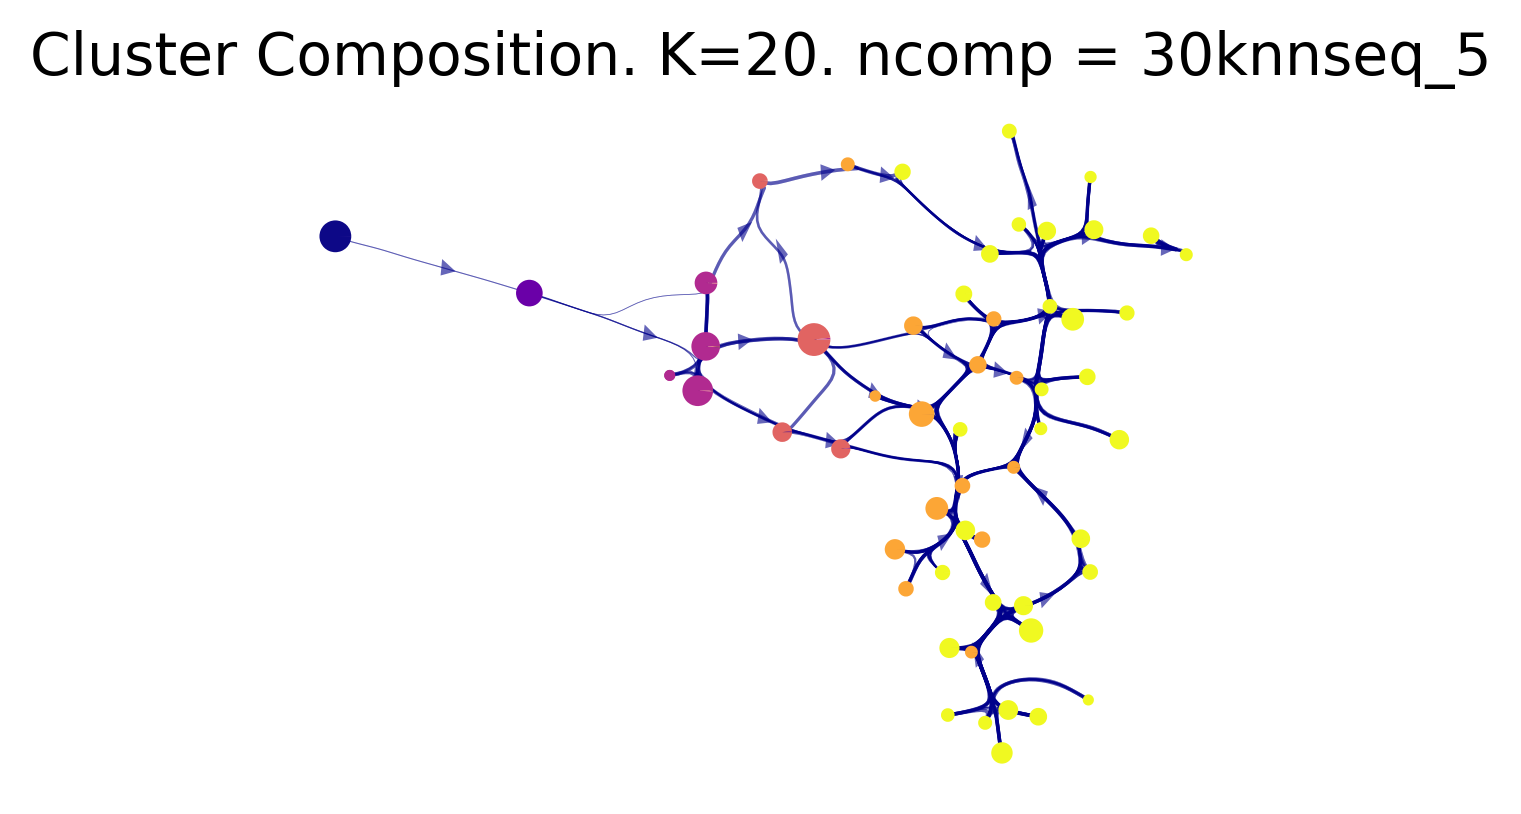

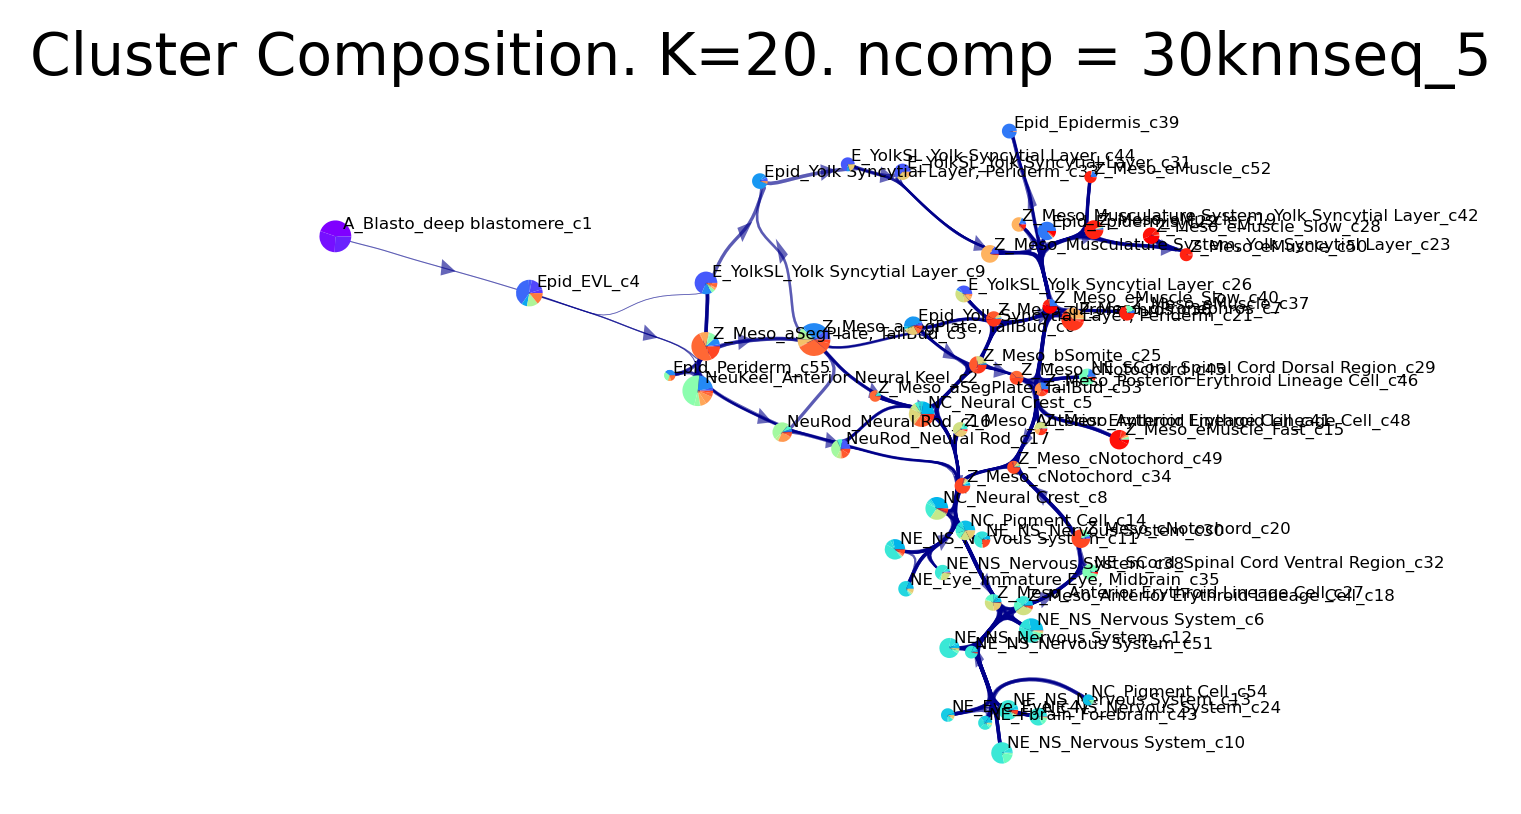

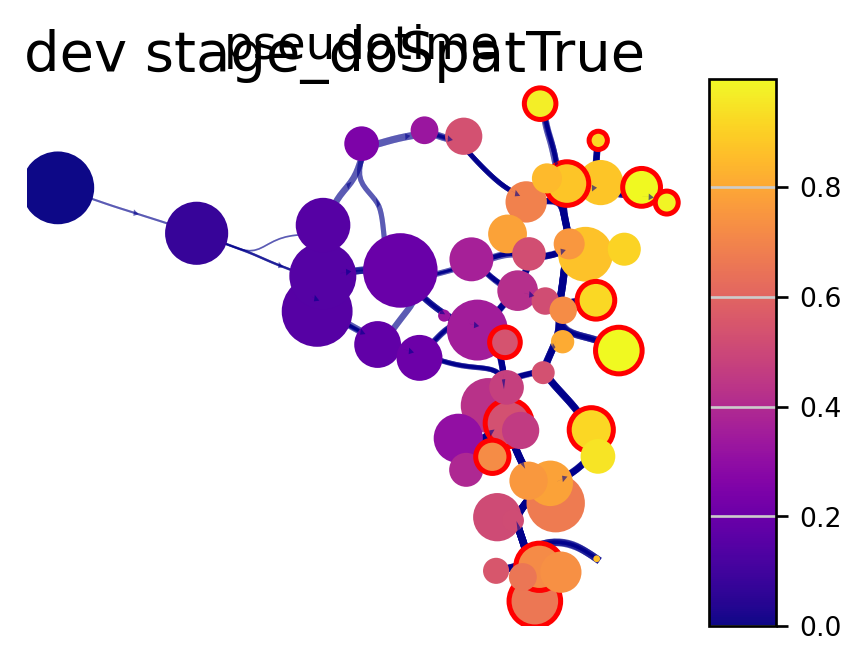

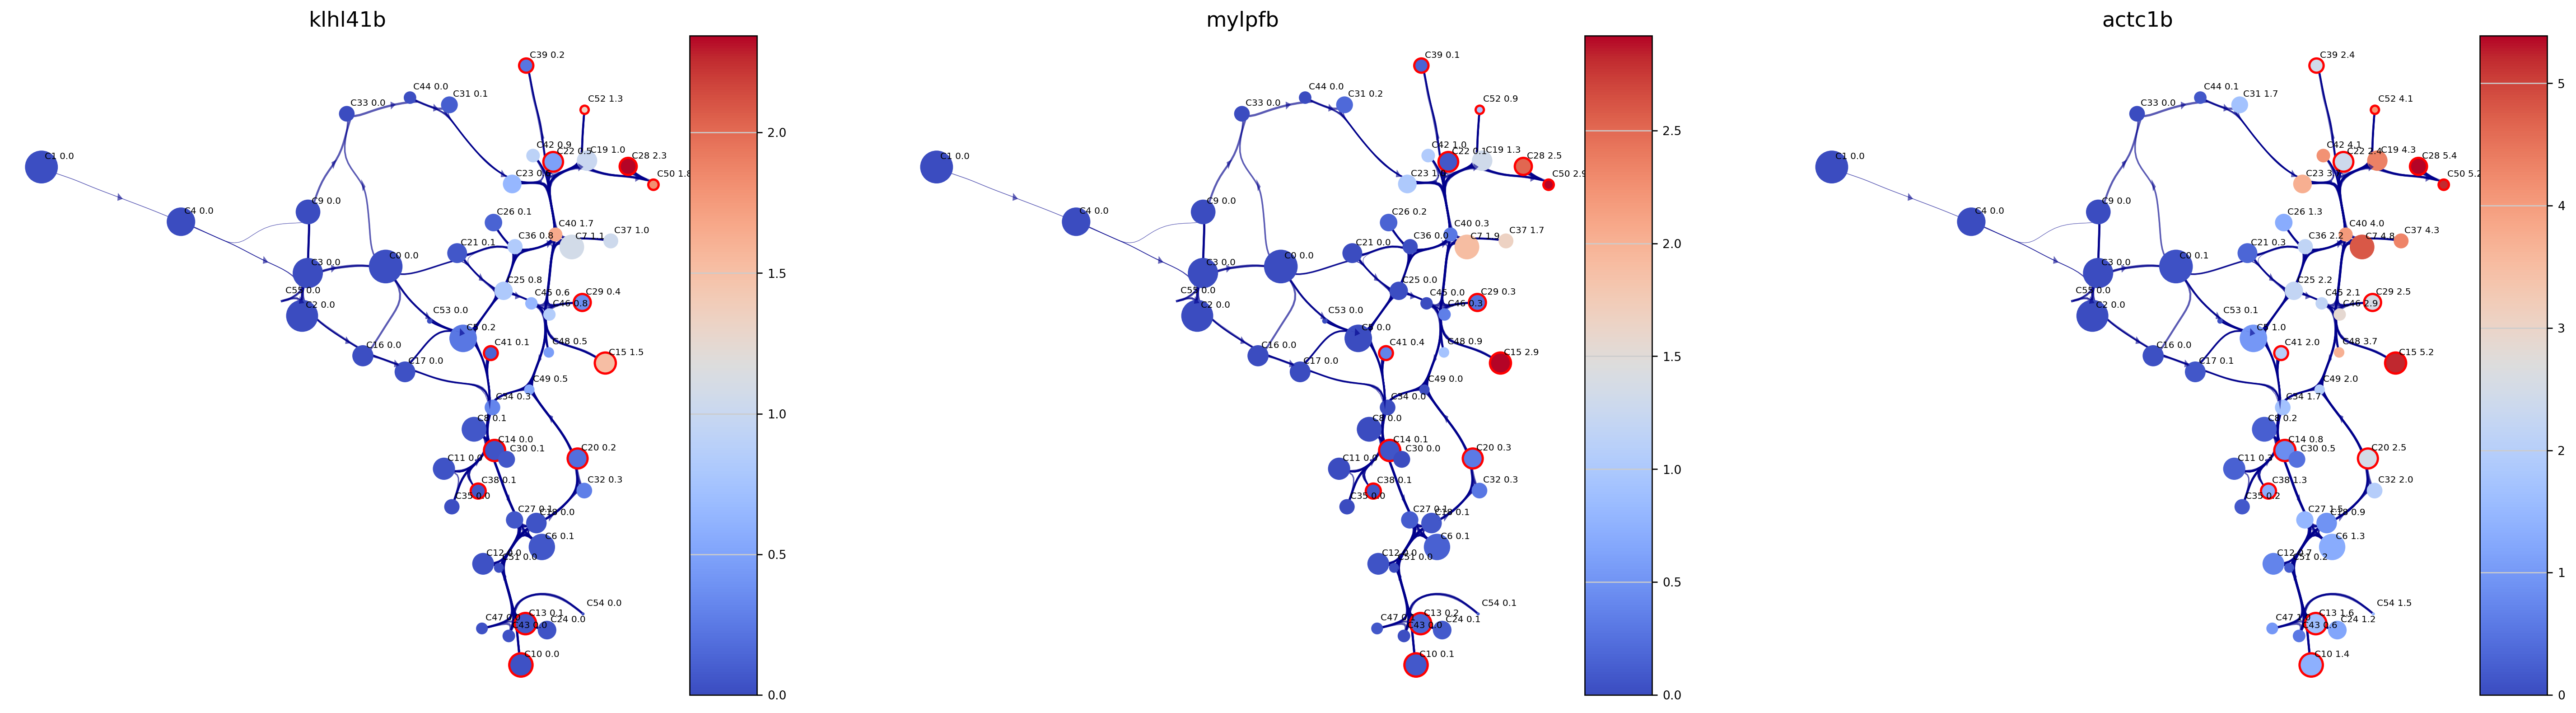

In [33]:
print(v1.terminal_clusters)
plot_viagraph_categorical = True

if plot_viagraph_categorical:
    #plotting viagraph colored by categorical labels (e.g. stages, cell types)
    f1, ax1 =via.plot_piechart_only_viagraph(via_object=v1, cmap_piechart='plasma',
                                                  pie_size_scale=0.4, linewidth_edge=0.6, ax_text=False,
                                                  reference_labels=time_numeric, headwidth_arrow=0.2,
                                                  highlight_terminal_clusters=True, show_legend=False)
    f1.set_size_inches(4,3)
    f2, ax2 = via.plot_piechart_only_viagraph(via_object=v1, cmap_piechart='rainbow',
                                                  pie_size_scale=0.4, linewidth_edge=0.6, ax_text=True,
                                                  reference_labels=true_labels_hybrid, headwidth_arrow=0.2,
                                                  highlight_terminal_clusters=True, show_legend=False, fontsize=4)
    f2.set_size_inches(4, 3)

plot_viagraph_continuous = True

if plot_viagraph_continuous:
    # plotting the viagraph colored by pseudotime, default edges
    # via.plot_viagraph(via_object=v0, tune_edges=False)
    # plotting the viagraph colored by pseudotime, tuning visualized edges
    # via.plot_viagraph(via_object=v0, tune_edges=True, cmap='viridis', initial_bandwidth=0.05, decay=0.7, edgebundle_pruning=0.5)

    f1, ax1 = via.plot_viagraph(via_object=v1, cmap='plasma',
                                              edgeweight_scale=1.5, label_text=False)
                                              
                                             
    f1.set_size_inches(4, 3)
    f1.suptitle('dev stage' + '_doSpat' + str(do_spatial))
    genes = ['klhl41b', 'mylpfb', 'actc1b'] #muscle related genes.
    df_genes_sc = pd.DataFrame(adata[:, genes].X.todense(), columns=genes)
    f2, ax1 = via.plot_viagraph(via_object=v1, df_genes=df_genes_sc, gene_list=genes,
                                              edgeweight_scale=1, label_text=True    )
    f2.set_size_inches(30, 8)
    

#### Running StaVia with prior clusters and terminal states 
Let's say you are very happy with the clusters you have computed based on previous run using StaVia, or you would like to use a subset of the terminal states it has identified, or even modify the list of terminal states and provide some more user defined guidance. In StaVia you can pass these on as input parameters to fix the clusters and terminal states in the following manner
- the user definted terminal states can be provided as group level fates that correspond to the labels found in the "true_label" parameter OR can be given as a list of single-cell indices as user_defined_terminal_cells = ['list of numeric indices of cells'].
- in the example below we use clusters that were identified in prior runs of StaVia as terminal cell fatesm as the user_defined_terminal_group. We therefore need to ensure that these labels exist in the true_label parameter

In [18]:
pre_labels = [int(i) for i in adata.obs['via_clusters']]
v0 = via.VIA(data=input, true_label=pre_labels,
             edgepruning_clustering_resolution=edgepruning_clustering_resolution, labels=pre_labels,
             edgepruning_clustering_resolution_local=1, knn=knn, knn_sequential=knn_sequential,
             knn_sequential_reverse=knn_sequential,
             cluster_graph_pruning=cluster_graph_pruning,resolution_parameter=resolution_parameter,
             root_user=root, random_seed=random_seed,user_defined_terminal_group=[26,46,10, 13, 17, 21, 24, 28, 30, 34, 36, 37, 39, 41, 43, 53, 61, 64, 65, 71,20,57,66,29,22] ,
             t_diff_step=t_diff_step,edgebundle_pruning=cluster_graph_pruning, edgebundle_pruning_twice=False,
             time_series_labels=time_numeric, time_series=time_series,
             spatial_aux=spatial_aux,
             do_spatial_knn=do_spatial, do_spatial_layout=False, spatial_coords=coords, spatial_knn=spatial_knn)

v0.run_VIA()


2024-05-08 10:05:00.530513	Running VIA over input data of 152977 (samples) x 30 (features)
2024-05-08 10:05:00.530596	Knngraph has 20 neighbors
2024-05-08 10:05:32.807649	Using time series information to guide knn graph construction 
2024-05-08 10:05:32.810528	Time series ordered set [3, 5, 10, 12, 18, 24]
2024-05-08 10:06:26.467705	Shape neighbors (152977, 20) and sequential neighbors (152977, 10)
2024-05-08 10:06:26.503122	Shape augmented neighbors (152977, 30)
2024-05-08 10:06:26.527353	Actual average allowable time difference between nodes is 8.4
2024-05-08 10:06:35.594145	Using spatial information to guide knn graph construction + combining with time-series data
2024-05-08 10:06:35.597896	These slices are present: ['10_1', '10_10', '10_11', '10_12', '10_13', '10_14', '10_15', '10_16', '10_17', '10_18', '10_19', '10_2', '10_20', '10_21', '10_22', '10_23', '10_24', '10_25', '10_26', '10_3', '10_4', '10_5', '10_6', '10_7', '10_8', '10_9', '12_1', '12_10', '12_11', '12_12', '12_2', '1

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pecanpy/graph.py:90: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  warnings.warn(


  0%|          | 0/1300 [00:00<?, ?it/s]

memory for rw2 hittings times  2. Using rw2 based pt
2024-05-08 10:08:00.280761	Terminal cluster list based on user defined cells/groups: [(26, 26), (46, 46), (10, 10), (13, 13), (17, 17), (21, 21), (24, 24), (28, 28), (30, 30), (34, 34), (36, 36), (37, 37), (39, 39), (41, 41), (43, 43), (53, 53), (61, 61), (64, 64), (65, 65), (71, 71), (20, 20), (57, 57), (66, 66), (29, 29), (22, 22)]
2024-05-08 10:08:00.281035	Terminal clusters corresponding to unique lineages in this component are [26, 46, 10, 13, 17, 21, 24, 28, 30, 34, 36, 37, 39, 41, 43, 53, 61, 64, 65, 71, 20, 57, 66, 29, 22] 
2024-05-08 10:08:00.281060	Calculating lineage probability at memory 5


/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pecanpy/graph.py:90: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-05-08 10:08:06.638440	Cluster or terminal cell fate 26 is reached 576.0 times
2024-05-08 10:08:06.719356	Cluster or terminal cell fate 46 is reached 924.0 times
2024-05-08 10:08:06.862167	Cluster or terminal cell fate 10 is reached 99.0 times
2024-05-08 10:08:07.005036	Cluster or terminal cell fate 13 is reached 670.0 times
2024-05-08 10:08:07.239039	Cluster or terminal cell fate 17 is reached 239.0 times
2024-05-08 10:08:07.344238	Cluster or terminal cell fate 21 is reached 442.0 times
2024-05-08 10:08:07.438323	Cluster or terminal cell fate 24 is reached 883.0 times
2024-05-08 10:08:07.560577	Cluster or terminal cell fate 28 is reached 918.0 times
2024-05-08 10:08:07.721966	Cluster or terminal cell fate 30 is reached 770.0 times
2024-05-08 10:08:07.833380	Cluster or terminal cell fate 34 is reached 966.0 times
2024-05-08 10:08:07.924998	Cluster or terminal cell fate 36 is reached 898.0 times
2024-05-08 10:08:08.098273	Cluster or terminal cell fate 37 is reached 626.0 times
2024-

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


2024-05-08 10:08:20.343423	Time elapsed 172.2 seconds


/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pyVIA/plotting_via.py:3513: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(node_pos[:, 0], node_pos[:, 1],
/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pyVIA/plotting_via.py:3513: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(node_pos[:, 0], node_pos[:, 1],


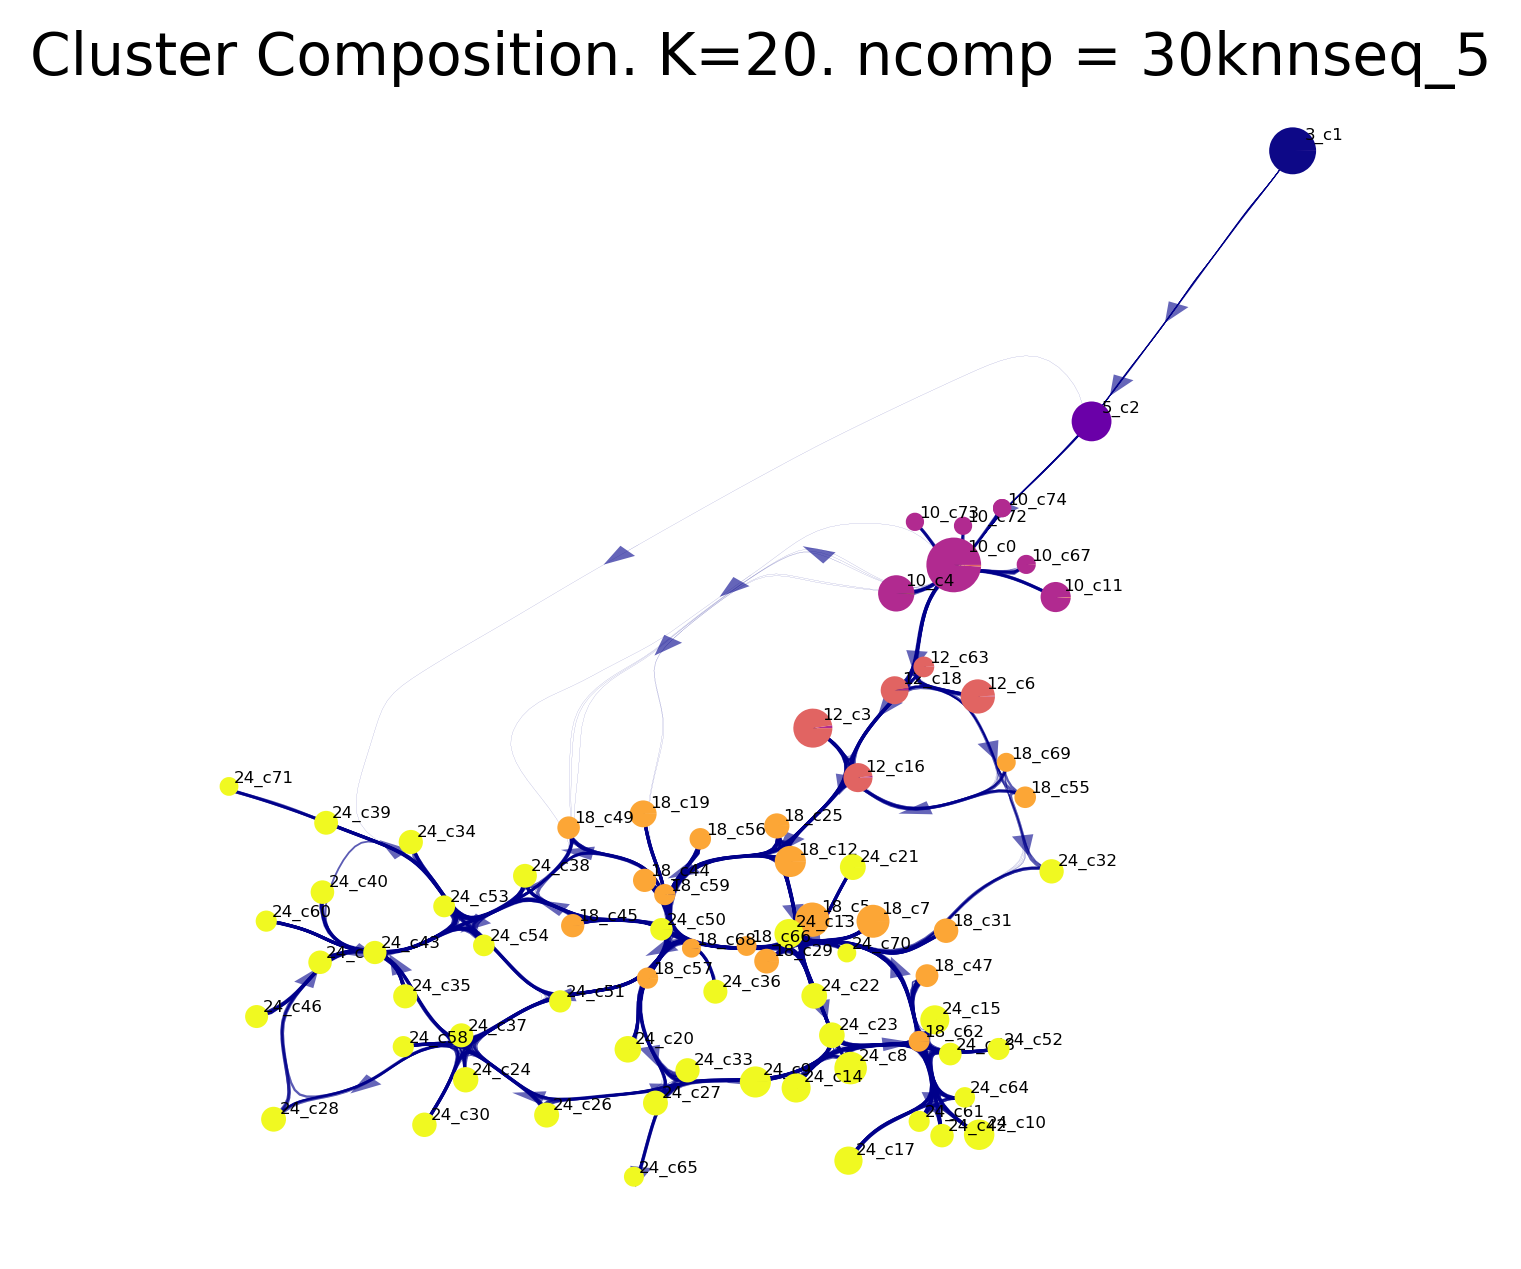

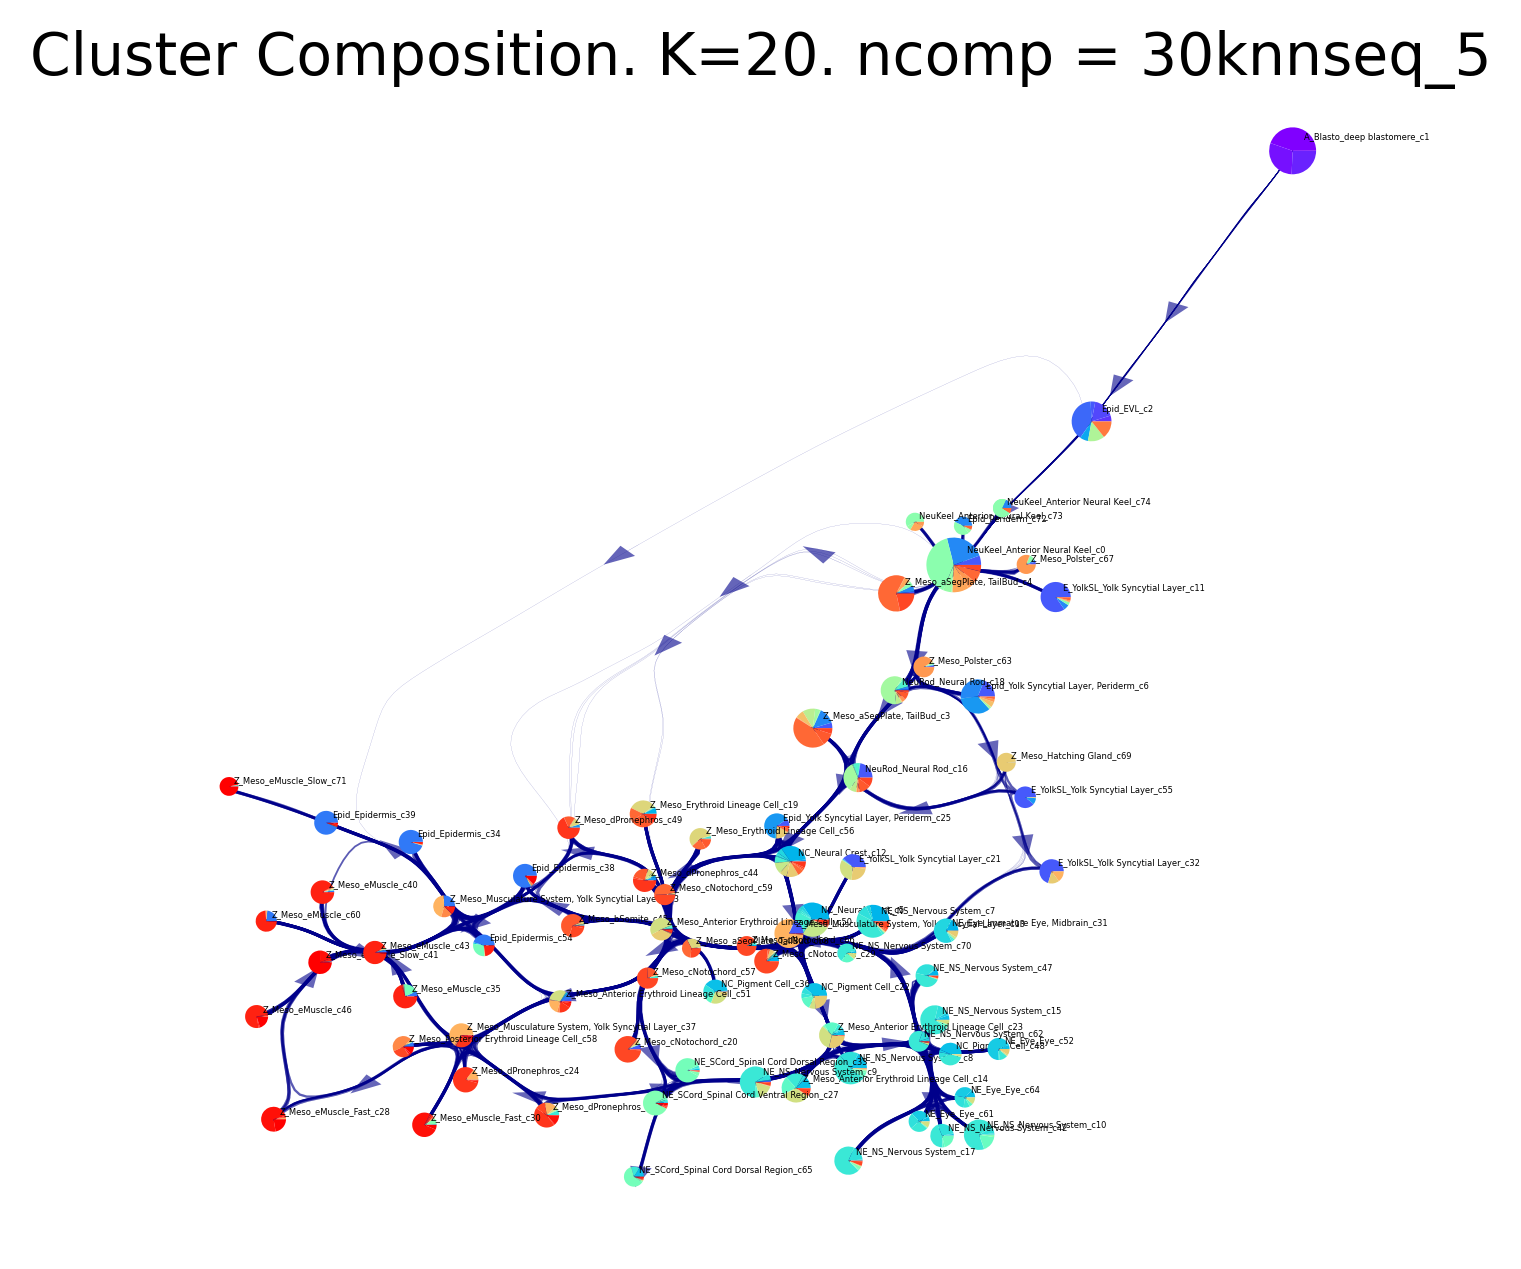

In [32]:
plot_viagraph_categorical = True

if plot_viagraph_categorical:
    #plotting viagraph colored by categorical labels (e.g. stages, cell types)
    f1, ax1 =via.plot_piechart_only_viagraph(via_object=v0, cmap_piechart='plasma',
                                                  pie_size_scale=0.4, linewidth_edge=0.6, ax_text=True, fontsize=4,
                                                  reference_labels=time_numeric, headwidth_arrow=0.2,
                                                  highlight_terminal_clusters=True, show_legend=False)
    f1.set_size_inches(5,5)
    
    f2, ax2 = via.plot_piechart_only_viagraph(via_object=v0, cmap_piechart='rainbow',
                                                  pie_size_scale=0.4, linewidth_edge=0.6, ax_text=True,
                                                  reference_labels=true_labels_hybrid, headwidth_arrow=0.2,
                                                  highlight_terminal_clusters=True, show_legend=False, fontsize=2)
    f2.set_size_inches(5,5)

#### Plotting clusters on tissue
- Option 1: You can plot all the clusters (the plots will be generated by cell type and group clusters in the same celltype into a figure with subplots)
- Option 2: Plot selected cell types or clusters only
- `reference_labels` is  an optional list of single-cell labels (e.g. time, annotation). This will plot (in a light background gray) all cells in the data that belong to the majority reference type of this cluster. ALso used in the title of each subplot to note the majority cell (ref2) type for each cluster
- `reference_labels2` is optional list of single-cell labels (e.g. time, annotation). this will be used in the title of each subplot to note the majority cell (ref2) type for each cluster`

df_coords_majref  shape (19102, 2)
df_coords_majref  shape (16733, 2)
df_coords_majref  shape (30848, 2)
df_coords_majref  shape (72175, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


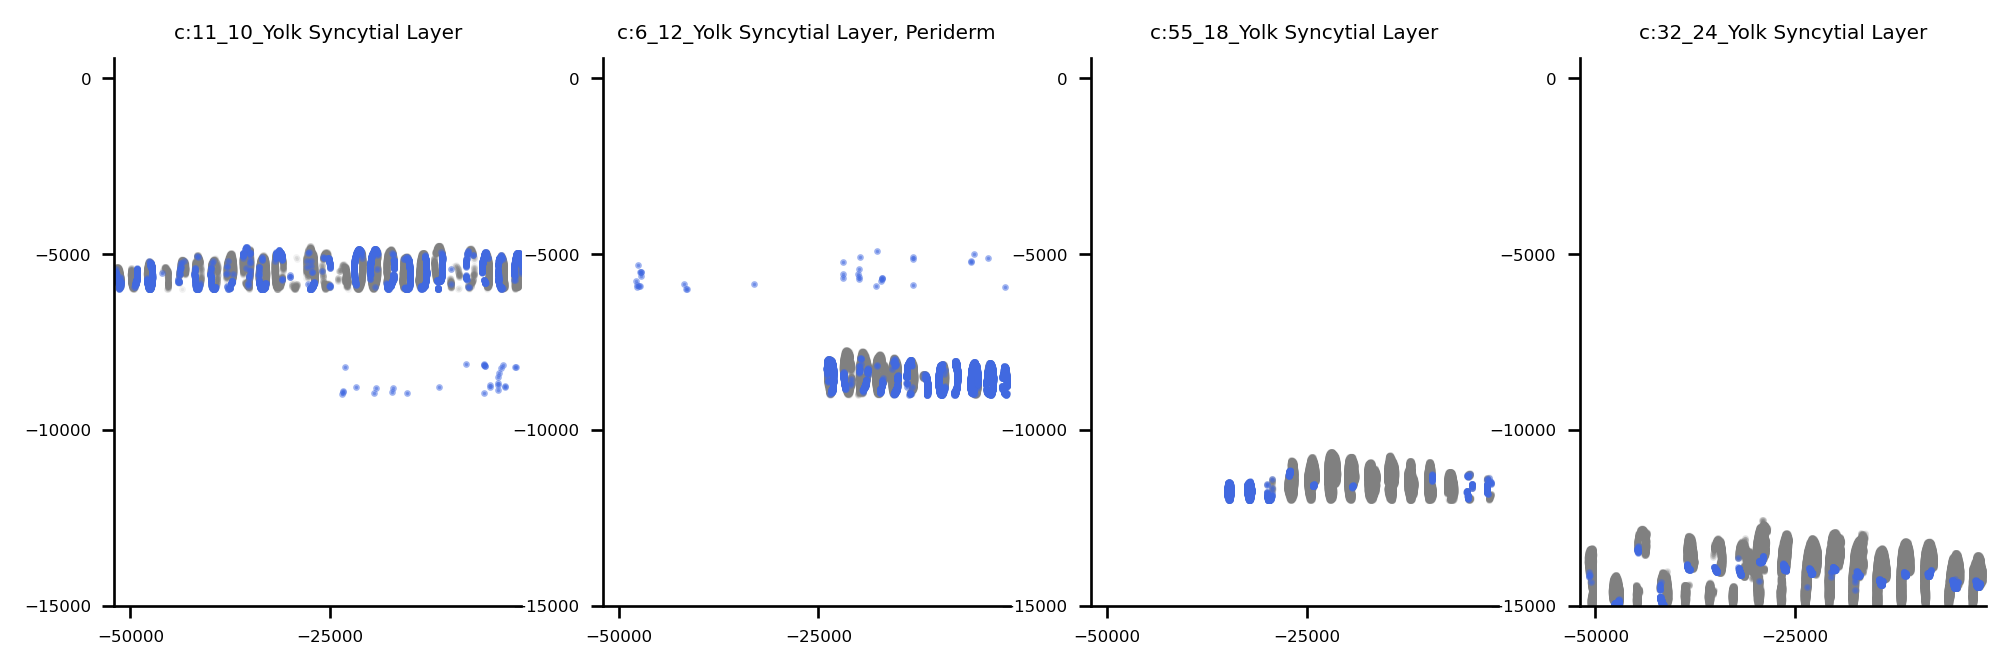

In [44]:
'''
# Option 1
list_of_figs = via.plot_all_spatial_clusters(spatial_coords=coords, true_label=true_labels_coarse,
                                             via_labels=pre_labels, alpha=0.5, s=1, verbose=True, reference_labels=time_numeric, reference_labels2=true_labels_fine)
'''
# Option 2
ysl_clus = [[11, 6, 55, 32],'royalblue'] #YSL
meso_clus = [[4, 63, 3, 45, 56, 57, 41, 50, 58] , 'red'] #eryt+muscle
noto_clus = [[57, 20], 'orange']
ns_clus = [[0, 18, 31, 7, 52, 14, 8] , 'turqoise'] #eye+ns
nc_clus = [[5, 12, 22, 23] ,'deepskyblue'] #neural crest+pigment

celltype_to_plot = ysl_clus
f, axs = via.plot_clusters_spatial(spatial_coords=coords, via_labels=pre_labels,  clusters=celltype_to_plot[0], color=celltype_to_plot[1],
                          reference_labels=time_numeric, reference_labels2=true_labels_fine, s=1 )
f.set_size_inches(10,3)
for ax in axs:
    ax.title.set_size(6)

#### Plot the lineage paths on the tissue slices
Let's have a look at what the recovered single-cell lineage probabilities towards different cell fates actually look like on the tissue slices. This gives us an idea of which cells and what locations of the tissue/embryo are actually involved or active in the emergence of different fates. 

plot lineage prob
2024-05-09 09:16:06.485576	Marker_lineages: [43]
2024-05-09 09:16:06.614552	The number of components in the original full graph is 1
2024-05-09 09:16:06.614597	For downstream visualization purposes we are also constructing a low knn-graph 
2024-05-09 09:24:36.018370	Check sc pb 1.0 
f getting majority comp
2024-05-09 09:24:40.901534	Cluster path on clustergraph starting from Root Cluster 1 to Terminal Cluster 43: [1, 2, 4, 0, 18, 7, 66, 59, 57, 45, 35, 40, 43]
setting vmin to 0.03582004258667322
2024-05-09 09:24:41.162092	Revised Cluster level path on sc-knnGraph from Root Cluster 1 to Terminal Cluster 43 along path: [1, 1, 1, 2, 68, 3, 6, 25, 21, 9, 43, 43, 43, 43]
2024-05-09 09:24:41.183995	Marker_lineages: [13]
2024-05-09 09:24:41.289809	The number of components in the original full graph is 1
2024-05-09 09:24:41.289853	For downstream visualization purposes we are also constructing a low knn-graph 
2024-05-09 09:33:58.441712	Check sc pb 1.0 
f getting majority comp

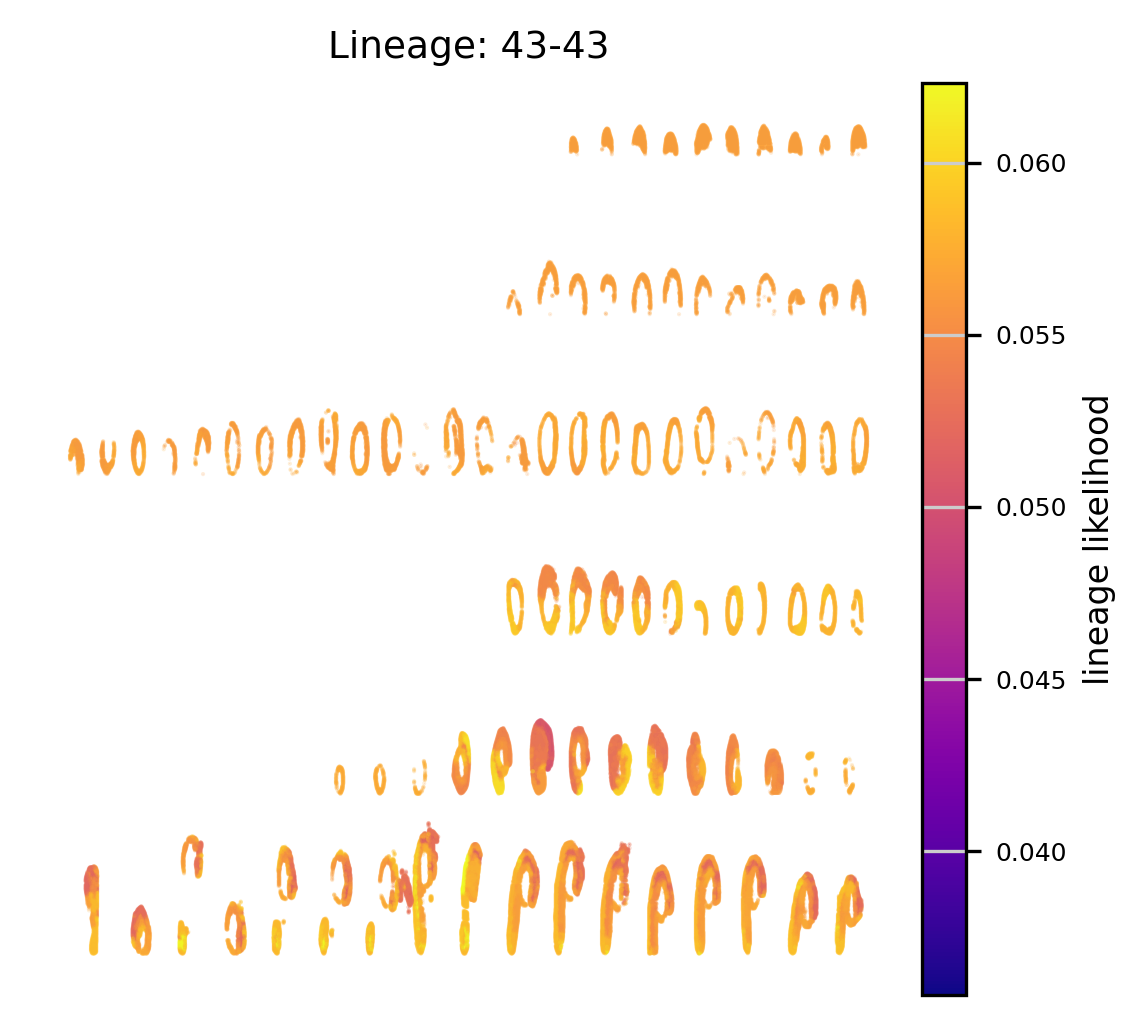

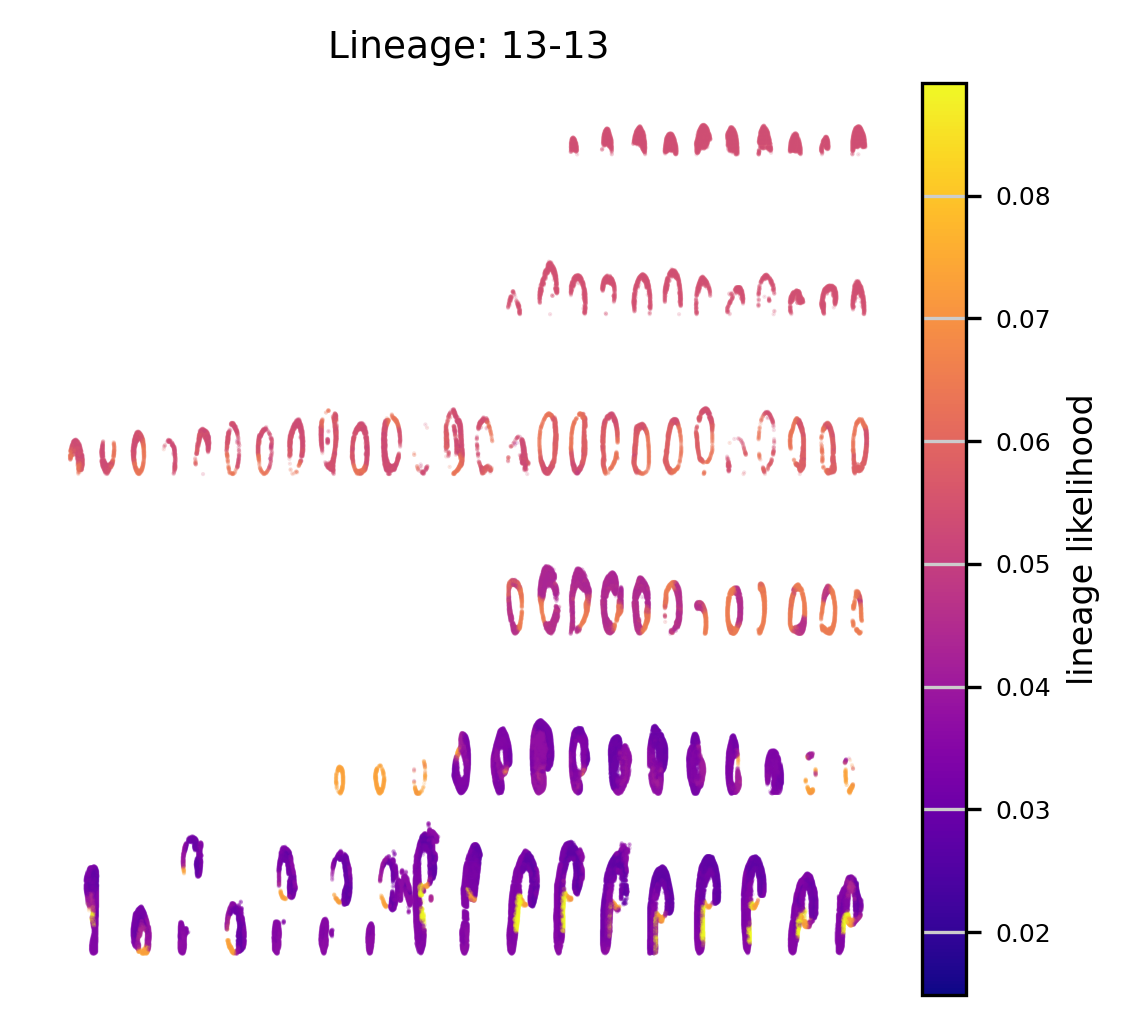

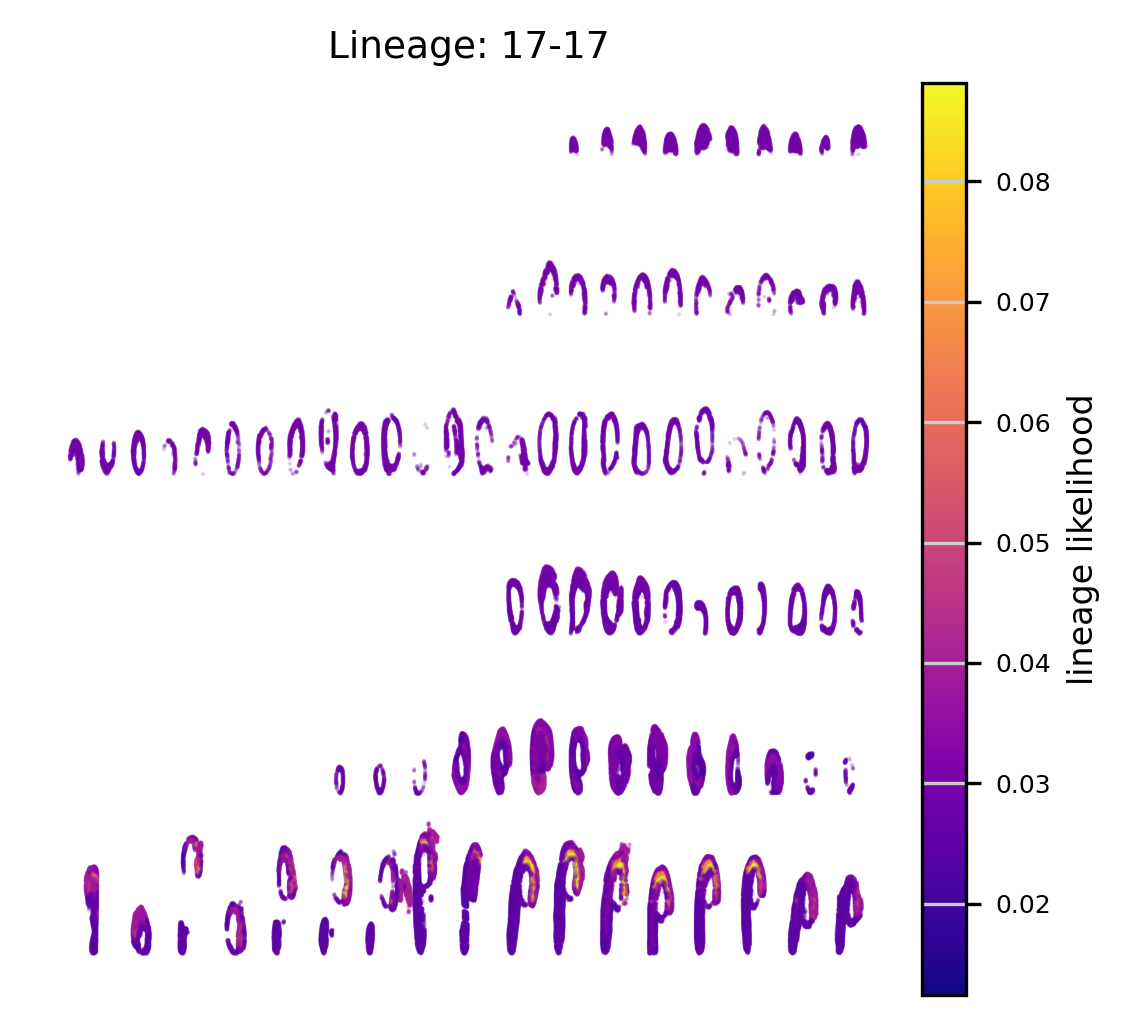

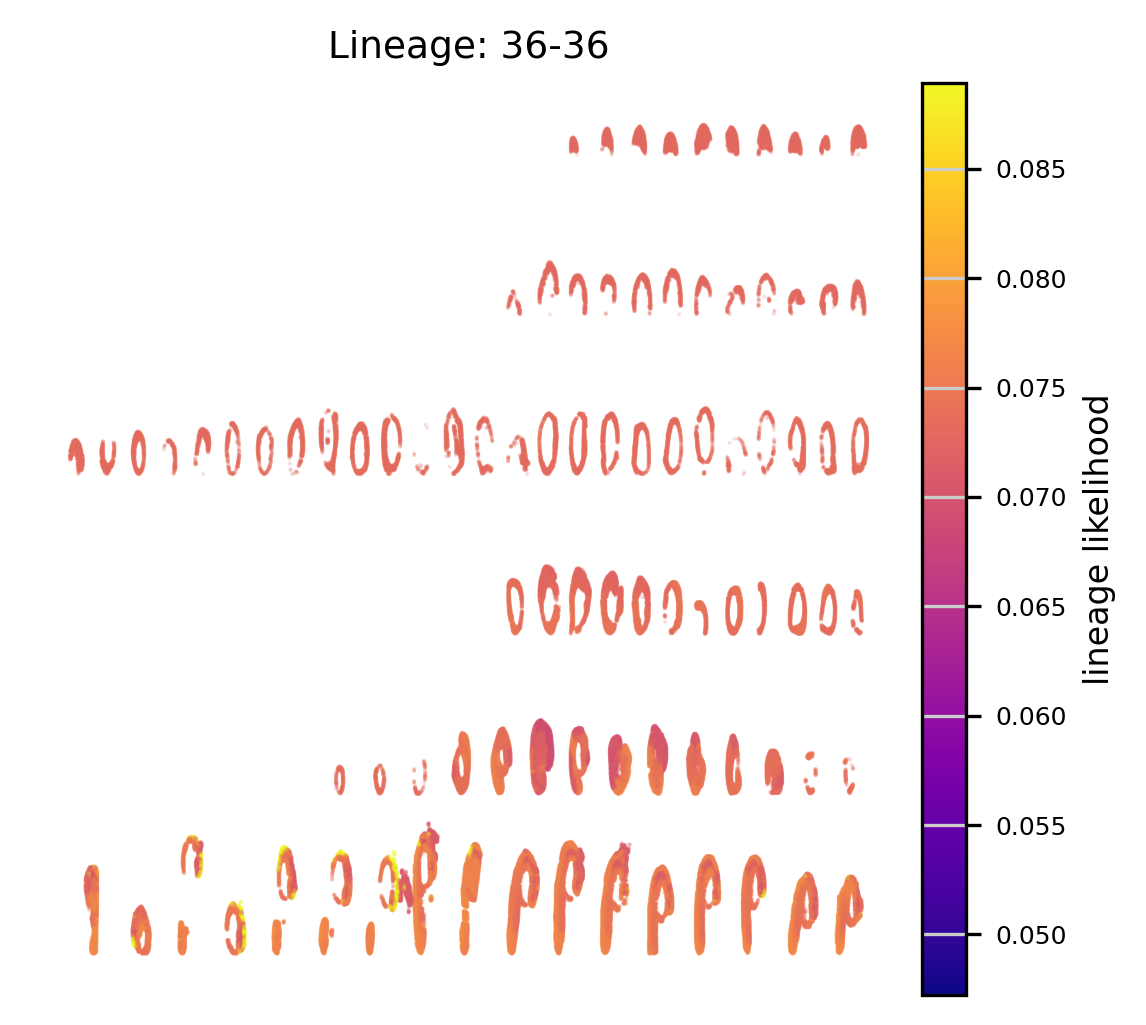

In [45]:
v0.terminal_clusters
print('plot lineage prob')
for ts_i in [43,13,17,36]:  
    via.plot_sc_lineage_probability(via_object=v0, embedding=coords, marker_lineages=[ts_i],
                                    scatter_size=1)
